In [1]:
import pandas as pd
import numpy as np
from scipy.special import softmax
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

import cv2

import os
import re

import keras
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from transformers import AutoTokenizer, TFDistilBertModel, TFAutoModel, Trainer, TrainingArguments,TFAutoModelForSequenceClassification



c:\Users\gsevr\cudaenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('MELD.Raw/train_sent_emo.csv',encoding='utf-8')
df['Utterance'] = df.Utterance.str.replace('',"'")

emotions = ['negative', 'neutral', 'positive']

In [3]:
optimizer = 'adam'
loss = 'categorical_crossentropy'
batch_size = 64
metrics = ['accuracy',
        #    keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None),
         #   keras.metrics.AUC(num_thresholds=200,curve="ROC",summation_method="interpolation",name='auc',dtype=None,thresholds=None, multi_label=True,num_labels=3,label_weights=None,from_logits=False),
        #    keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None),
        #    keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)
           ]




early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  
    patience=8,          
    verbose=4,           
    restore_best_weights=True)

In [4]:
min_size = df.Sentiment.value_counts().min()

dataframes = []

for emotion in df.Sentiment.unique():
    dataframes.append(df[df.Sentiment == emotion].sample(min_size, ignore_index=True))

df = pd.concat(dataframes, ignore_index=True)           
df = df.sample(frac=0.7, ignore_index=True)
df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,3470,Gone! I mean its amazing Pheebs. I feel so fre...,Rachel,joy,positive,345,4,6,7,"00:19:17,614","00:19:25,538"
1,7658,"Oh, I'm sorry, am I getting in the way of all ...",Chandler,anger,negative,770,9,5,5,"00:08:47,485","00:08:50,695"
2,7980,"Okay, I'm sorry.",Rachel,sadness,negative,804,9,4,4,"00:01:48,942","00:01:50,651"
3,10156,Hi! Bye!,Chandler,neutral,neutral,1011,3,3,5,"0:13:50,288","0:13:52,615"
4,4039,"Ahh, Gepeto, $5,000 dollars? Are you insane?",Chandler,surprise,negative,412,11,4,2,"00:04:50,623","00:04:52,416"
...,...,...,...,...,...,...,...,...,...,...,...
4896,5791,"No, I can't get it out.",Ross,sadness,negative,585,12,3,6,"0:20:37,861","0:20:38,223"
4897,7226,"No, the quiet down thing!",Joey,anger,negative,720,9,5,7,"00:10:06,814","00:10:08,898"
4898,1382,"When they're hungry enough, they'll come in.",Joey,neutral,neutral,143,4,3,9,"00:22:06,116","00:22:08,200"
4899,10206,I ate a bug.,Phoebe,disgust,negative,1016,9,3,17,"00:15:24,298","00:15:26,215"


In [5]:
face_model = tf.keras.applications.VGG16(input_shape=(48,48,3),
                                        include_top=False,
                                        weights="imagenet") #include_top=True for predictions, False for embeddings

In [6]:
# from keras_vggface.vggface import VGGFace

# # VGGFace model
# face_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), pooling='avg')


In [7]:
import sys

def find_largest_global():
    largest_var_name = None
    largest_size = 0

    for var_name, var_value in globals().items():
        # Skip built-in modules and functions
        if not var_name.startswith('__') and not callable(var_value):
            size = sys.getsizeof(var_value)
            if size > largest_size:
                largest_size = size
                largest_var_name = var_name

    return largest_var_name, largest_size

The following produces detector embeddings without the use of a NN model.

In [8]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (48, 48))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face  # Return the first face for consistency with the original code

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'MELD.Raw/train_splits/'
one_face_videos = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            one_face_videos[file_name] = single_video_embeddings
        else:
            one_face_videos[file_name] = 'too many faces' 



In [9]:
df['many_faces'] = one_face_videos.values()
df['wrong_shape'] = [np.array(value).shape for value in one_face_videos.values() if value != None]

df = df[(df.many_faces != 'too many faces') & (df.wrong_shape == (1,48,48,3))]



In [10]:
split_size = int(len(df) * 0.8)


In [11]:
def preprocess(text):
    t = text.lower()
    t = re.sub('\d+',r'',t)
    t = re.sub(r'\W+',r' ',t)
    return t

lemmatizer = WordNetLemmatizer()



df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])
                .strip() for txt in df['Utterance']]

C:\Users\gsevr\AppData\Local\Temp\ipykernel_20620\2616501896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])


In [12]:
ohe = OneHotEncoder(categories=[['negative', 'neutral', 'positive']])
labels = ohe.fit_transform(df.Sentiment.to_numpy().reshape(-1,1)).toarray()
labels_train = labels[:split_size]
labels_val = labels[split_size:]

In [13]:
df_train = df.iloc[:split_size]
df_val = df.iloc[split_size:]

The following uses detector embeddings to fine tune the VGG16 model

In [14]:
#this includes transfer learning for vgg16 and makes predictions based on that.
from tensorflow.keras.layers import BatchNormalization, Activation

for layer in face_model.layers[:-4]:
    layer.trainable=False

# for layer in face_model.layers[-4:]:
#     layer.trainable = True

base = face_model.output

vid_pred_model = Sequential()
vid_pred_model.add(face_model)
# vid_pred_model.add(Dropout(0.2))
vid_pred_model.add(Flatten())
# vid_pred_model.add(BatchNormalization())
vid_pred_model.add(Dense(32, activation='relu'))
# vid_pred_model.add(BatchNormalization())
# vid_pred_model.add(Dropout(0.2))
# vid_pred_model.add(Dense(64,kernel_initializer='he_uniform', kernel_regularizer=regularizers.L2()))
# vid_pred_model.add(BatchNormalization())
# vid_pred_model.add(Activation('relu'))
# vid_pred_model.add(Dropout(0.5))
vid_pred_model.add(Dense(16,activation='relu'))
# vid_pred_model.add(BatchNormalization())
vid_pred_model.add(Dense(3,activation='softmax'))

vid_pred_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)



In [15]:
vid_train_data = []
for video in [value for value in one_face_videos.values() if value != None and np.array(value).shape == (1,48,48,3)]:
    video = tf.reduce_mean(video,axis=0)
    vid_train_data.append(video)

vid_train = np.array(vid_train_data)[:split_size]
vid_val = np.array(vid_train_data)[split_size:]

In [16]:
history_vid_pred = vid_pred_model.fit(vid_train,labels_train,epochs=5, validation_data=(vid_val,labels_val), batch_size=32)

Epoch 1/5
108/108 [==============================] - 398s 4s/step - loss: 1.1164 - accuracy: 0.3334 - val_loss: 1.0990 - val_accuracy: 0.3476
Epoch 2/5
108/108 [==============================] - 391s 4s/step - loss: 1.0999 - accuracy: 0.3300 - val_loss: 1.0985 - val_accuracy: 0.3523
Epoch 3/5
108/108 [==============================] - 388s 4s/step - loss: 1.0996 - accuracy: 0.3395 - val_loss: 1.0988 - val_accuracy: 0.3476
Epoch 4/5
108/108 [==============================] - 388s 4s/step - loss: 1.1045 - accuracy: 0.3323 - val_loss: 1.0983 - val_accuracy: 0.3372
Epoch 5/5
108/108 [==============================] - 389s 4s/step - loss: 1.0990 - accuracy: 0.3366 - val_loss: 1.0998 - val_accuracy: 0.3302


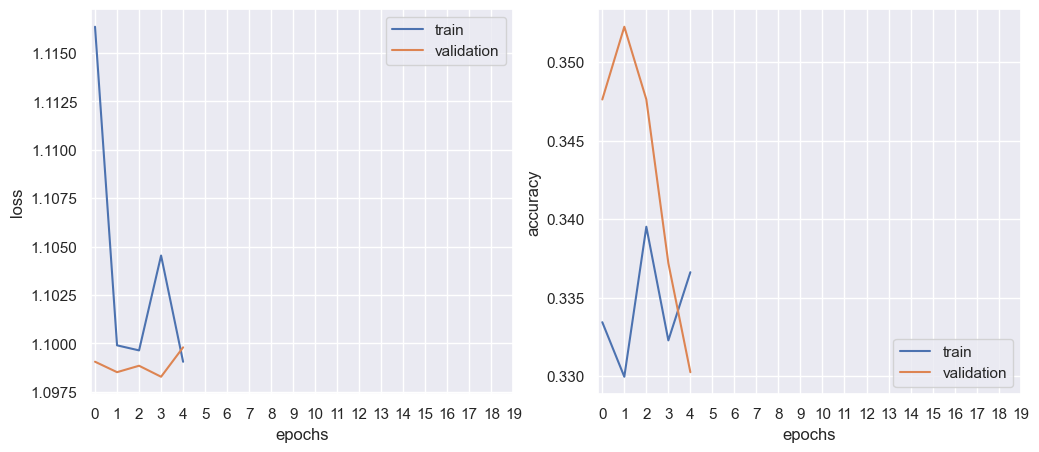

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vid_pred.history['loss'])
plt.plot(history_vid_pred.history['val_loss'])
plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history_vid_pred.history['accuracy'])
plt.plot(history_vid_pred.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,20)])

plt.show()

In [18]:
# video predictions

video_predictions = vid_pred_model.predict(vid_val)
video_predictions


27/27 [==============================] - 27s 1s/step


array([[0.32904   , 0.3195366 , 0.35142344],
       [0.33009547, 0.3198323 , 0.3500722 ],
       [0.3289694 , 0.32011244, 0.35091817],
       ...,
       [0.3304731 , 0.32200533, 0.34752154],
       [0.32752758, 0.3211877 , 0.35128468],
       [0.32763007, 0.32149133, 0.3508786 ]], dtype=float32)

In [19]:
# this is designed to extract the embeddings from the fine tuned model

video_embedding_layers = [layer for layer in vid_pred_model.layers[:-3]]

video_embedding_model_input = vid_pred_model.input
video_embedding_model_output = video_embedding_layers[-1].output
video_embedding_model = Model(video_embedding_model_input, video_embedding_model_output)

video_embedding_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [20]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face  # Return the first face for consistency with the original code

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'MELD.Raw/train_splits/'
video_embeddings = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            video_embeddings[file_name] = single_video_embeddings
        else:
            video_embeddings[file_name] = 'too many faces' 



In [21]:
from transformers import RobertaConfig
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
# model_name = 'bhadresh-savani/distilbert-base-uncased-emotion'
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = RobertaConfig.from_pretrained(model_name, output_hidden_states=True)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, config=config)



All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [22]:
train_encodings = tokenizer([text for text in df_train.Utterance.values], return_tensors='tf', padding=True, truncation=True)
val_encodings = tokenizer([text for text in df_val.Utterance.values], return_tensors='tf', padding=True, truncation=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [23]:
train_preds = model(**train_encodings)
val_preds = model(**val_encodings)

In [24]:
text_preds = softmax(val_preds[0],axis=1)

p = [emotions[i] for i in np.argmax(text_preds,axis=1)]

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(df_val.Sentiment.values, p)

accuracy_score(df_val.Sentiment.values, p)

0.5538818076477404

In [26]:
# THIS GETS EMBEDDINGS FROM DF

df_encodings = tokenizer([text for text in df.Utterance.values], return_tensors='tf', padding=True, truncation=True)
df_preds = model(**df_encodings)
df_text_preds = softmax(df_preds[0],axis=1)
text_embeddings = df_preds[1]
text_embeddings



(<tf.Tensor: shape=(4315, 92, 768), dtype=float32, numpy=
 array([[[ 0.13776219, -0.07992195, -0.00446574, ..., -0.04688763,
           0.05868359,  0.04299733],
         [-0.2836169 ,  0.24480425,  0.08705112, ...,  0.19579616,
           0.28168452,  0.43177885],
         [ 0.03398462, -0.305734  ,  0.16561113, ...,  0.00878342,
          -0.04137747,  0.5311708 ],
         ...,
         [-0.50868213,  0.506925  ,  0.00080039, ..., -0.39926678,
           0.31462133, -0.36372456],
         [-0.50868213,  0.506925  ,  0.00080039, ..., -0.39926678,
           0.31462133, -0.36372456],
         [-0.50868213,  0.506925  ,  0.00080039, ..., -0.39926678,
           0.31462133, -0.36372456]],
 
        [[ 0.13776219, -0.07992195, -0.00446574, ..., -0.04688763,
           0.05868359,  0.04299733],
         [-0.16414547,  0.08631949,  0.79556084, ..., -0.15609926,
           0.17131662,  0.07776289],
         [ 0.39599666,  0.07245521, -0.03001726, ..., -0.58689195,
          -0.30259293,  0.

In [27]:
text_embeddings_fn = np.mean(text_embeddings[12],axis=1)
video_embeddings_array = np.array([embedding for embedding in video_embeddings.values() if embedding != 'too many faces'])
video_embeddings_array_fn = tf.reduce_mean(video_embeddings_array, axis=4).reshape(len(video_embeddings_array),-1)

con_ten = np.concatenate([text_embeddings_fn, video_embeddings_array_fn],axis=1)


In [28]:
fusion_data = np.squeeze(np.array([con_ten],dtype=np.float16))
fusion_train = fusion_data[:split_size]
fusion_val = fusion_data[split_size:]

In [29]:
# Model for early fusion

fusion_model = Sequential()

fusion_model.add(Dense(256, activation='relu'))
# fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(128, activation='relu'))
# fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(64, activation='relu'))
# fusion_model.add(Dropout(0.3))
fusion_model.add(Dense(len(emotions), activation='softmax'))

fusion_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

fusion_model_history = fusion_model.fit(fusion_train,labels_train,epochs=20, validation_data=(fusion_val,labels_val), batch_size=batch_size, callbacks=[early_stopping_callback])

Epoch 1/20
54/54 [==============================] - 10s 185ms/step - loss: 2.4554 - accuracy: 0.4464 - val_loss: 1.1893 - val_accuracy: 0.5029
Epoch 2/20
54/54 [==============================] - 10s 177ms/step - loss: 1.2004 - accuracy: 0.5191 - val_loss: 1.1136 - val_accuracy: 0.5527
Epoch 3/20
54/54 [==============================] - 10s 177ms/step - loss: 0.9738 - accuracy: 0.5802 - val_loss: 0.9923 - val_accuracy: 0.5771
Epoch 4/20
54/54 [==============================] - 10s 178ms/step - loss: 0.8918 - accuracy: 0.6101 - val_loss: 0.9154 - val_accuracy: 0.5863
Epoch 5/20
54/54 [==============================] - 10s 177ms/step - loss: 0.9905 - accuracy: 0.5829 - val_loss: 0.8655 - val_accuracy: 0.6269
Epoch 6/20
54/54 [==============================] - 10s 177ms/step - loss: 0.9323 - accuracy: 0.6034 - val_loss: 0.8636 - val_accuracy: 0.6188
Epoch 7/20
54/54 [==============================] - 10s 177ms/step - loss: 0.8571 - accuracy: 0.6214 - val_loss: 1.0251 - val_accuracy: 0.5458

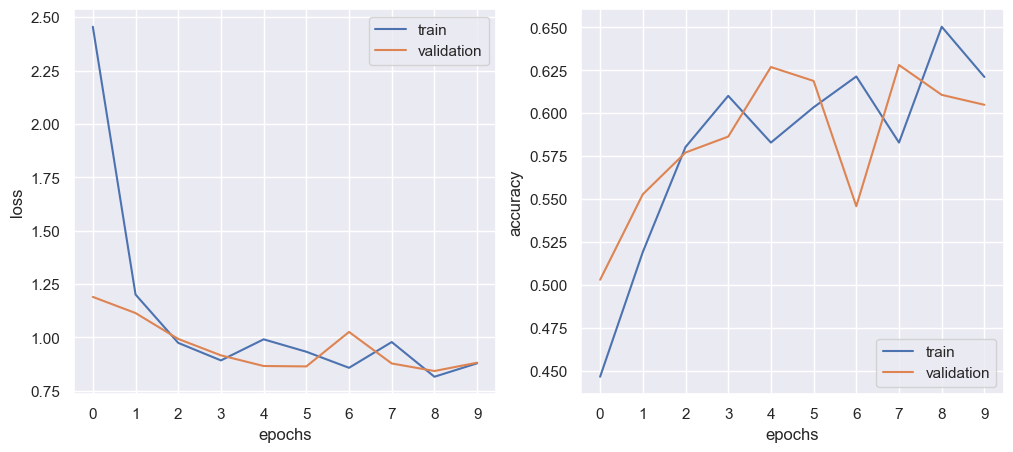

In [30]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fusion_model_history.history['loss'][:10])
plt.plot(fusion_model_history.history['val_loss'][:10])
plt.xticks([i for i in range(0,10)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(fusion_model_history.history['accuracy'][:10])
plt.plot(fusion_model_history.history['val_accuracy'][:10])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,10)])

plt.show()

In [31]:
# Late fusion

def final_preds(text_model_predictions, visual_model_predictions):
    final_predictions = []
    emotions = ['negative', 'neutral', 'positive']

    for text_pred, vis_pred in zip(text_model_predictions, visual_model_predictions):
        text_max = np.argmax(text_pred)
        vis_max = np.argmax(vis_pred)

        # Equal predictions
        if text_max == vis_max:
            final_prediction = emotions[text_max]
            print('Equal predictions')

        # Different predictions, lean towards higher confidence
        else:
            final_prediction_value = np.maximum(a := np.round(text_pred[text_max], 8), 
                                                b := np.round(vis_pred[vis_max], 8))

            try:
                print(f'Text: {a}, Visual: {b}')
                final_prediction = emotions[np.where(np.round(text_pred, 8) == final_prediction_value)[0][0]]
                print('Text wins')
            except IndexError:
                final_prediction = emotions[np.where(np.round(vis_pred, 8) == final_prediction_value)[0][0]]
                print('Visual wins')

        final_predictions.append(final_prediction)

    return final_predictions


In [32]:
late_fusion_predictions = final_preds(text_preds, video_predictions)

#TODO Confusion matrix

Equal predictions
Text: 0.5250452756881714, Visual: 0.3500722050666809
Text wins
Text: 0.4854649305343628, Visual: 0.350918173789978
Text wins
Text: 0.7795871496200562, Visual: 0.3520740270614624
Text wins
Equal predictions
Text: 0.8138222694396973, Visual: 0.35124075412750244
Text wins
Text: 0.4415622651576996, Visual: 0.3509674072265625
Text wins
Equal predictions
Text: 0.6355724334716797, Visual: 0.3545268774032593
Text wins
Text: 0.5614583492279053, Visual: 0.351459801197052
Text wins
Text: 0.6699426174163818, Visual: 0.3508208692073822
Text wins
Text: 0.5315029621124268, Visual: 0.34829410910606384
Text wins
Equal predictions
Equal predictions
Text: 0.6469645500183105, Visual: 0.3477186858654022
Text wins
Text: 0.5776457786560059, Visual: 0.34950709342956543
Text wins
Text: 0.4458564817905426, Visual: 0.349896639585495
Text wins
Equal predictions
Text: 0.5539417266845703, Visual: 0.35305118560791016
Text wins
Text: 0.9510526657104492, Visual: 0.352794349193573
Text wins
Equal pred

In [33]:

accuracy_score(df_val.Sentiment.values, late_fusion_predictions)

0.5538818076477404

In [34]:
confusion_matrix(df_val.Sentiment.values, late_fusion_predictions)

array([[126, 125,  33],
       [ 37, 217,  40],
       [ 37, 113, 135]], dtype=int64)

In [35]:
tved_df = pd.read_csv('TVED Dataset.csv')
tved_df

,utterance,sentiment,emotion,check,By,prepro
0,"01. ""Feeling down today, everything seems a bi...",negative,Sadness,True,A,feeling down today everything seems a bit grey
1,"02. ""Just can't shake off this feeling of heav...",negative,Sadness,True,A,just cant shake off this feeling of heaviness
2,"03. ""It's like a weight in my chest that won't...",negative,Sadness,True,A,its like a weight in my chest that wont go away
3,"04. ""Trying to find some light in this darknes...",negative,Sadness,True,A,trying to find some light in this darkness bu...
4,"05. ""Feeling a bit lost and not sure how to li...",negative,Sadness,True,I,feeling a bit lost and not sure how to lift m...
...,...,...,...,...,...,...
65,"06. ""Terrified about what might happen, need t...",negative,Fear,True,M,terrified about what might happen need to sta...
66,"07. ""Fearing the worst, trying to keep a brave...",negative,Fear,True,M,fearing the worst trying to keep a brave face
67,"08. ""Feeling a knot in my stomach, scared to m...",negative,Fear,True,E,feeling a knot in my stomach scared to move f...
68,"09. ""That was really frightening, still shaking.""",negative,Fear,True,E,that was really frightening still shaking


In [36]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (48, 48))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face  # Return the first face for consistency with the original code

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'Emotions dataset/Good/'
one_face_videos = {}

for idx, row in tved_df.iterrows():
    file_name = str(row['emotion']) + ' ' + row['utterance'][:2] + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            one_face_videos[file_name] = single_video_embeddings
        else:
            one_face_videos[file_name] = 'too many faces' 



In [37]:
tved_df['many_faces'] = one_face_videos.values()
tved_df['wrong_shape'] = [np.array(value).shape for value in one_face_videos.values() if value != None]

tved_df = tved_df[(tved_df.many_faces != 'too many faces') & (tved_df.wrong_shape == (1,48,48,3))]



In [38]:
tved_labels = ohe.fit_transform(tved_df.sentiment.to_numpy().reshape(-1,1)).toarray()


In [39]:
tved_vid_train_data = []
for video in [value for value in one_face_videos.values() if value != None and np.array(value).shape == (1,48,48,3)]:
    video = tf.reduce_mean(video,axis=0)
    tved_vid_train_data.append(video)

In [40]:
tved_vid_preds = vid_pred_model.predict(np.array(tved_vid_train_data))

3/3 [==============================] - 0s 97ms/step


In [41]:
p = np.argmax(tved_vid_preds,axis=1)

In [42]:
accuracy_score(np.argmax(tved_labels,axis=1),p)

0.2857142857142857

In [43]:


# Initialize Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        cropped_face = frame[y:y+h, x:x+w]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face  # Return the first face for consistency with the original code

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'Emotions dataset/Good/'
video_embeddings = {}

for idx, row in tved_df.iterrows():
    file_name = str(row['emotion']) + ' ' + row['utterance'][:2] + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 1:
            ret, frame = video_capture.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

            # check for exactly 1 face
            if len(faces) == 1:
                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes (optional visualization)
                # for (x, y, w, h) in faces:
                #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            video_embeddings[file_name] = single_video_embeddings
        else:
            video_embeddings[file_name] = 'too many faces' 



In [44]:
tved_encodings = tokenizer([text for text in tved_df.utterance.values], return_tensors='tf', padding=True, truncation=True)
tved_text_preds = model(**tved_encodings)
tved_text_preds = softmax(tved_text_preds[0],axis=1)
p = [emotions[i] for i in np.argmax(tved_text_preds,axis=1)]
accuracy_score(tved_df.sentiment.values, p)



0.8

In [45]:
tved_df_encodings = tokenizer([text for text in tved_df.utterance.values], return_tensors='tf', padding=True, truncation=True)
tved_df_preds = model(**tved_df_encodings)
tved_text_embeddings = tved_df_preds[1]
tved_text_embeddings

(<tf.Tensor: shape=(70, 20, 768), dtype=float32, numpy=
 array([[[ 1.37762189e-01, -7.99219534e-02, -4.46573924e-03, ...,
          -4.68876287e-02,  5.86835891e-02,  4.29973304e-02],
         [ 3.79110724e-02, -1.30037308e-01,  1.10452600e-01, ...,
          -3.41087878e-01, -5.84595084e-01,  1.10485815e-01],
         [ 2.92314142e-01, -5.71601987e-02,  3.89317982e-02, ...,
          -8.50661874e-01, -1.95080251e-01,  4.08580422e-01],
         ...,
         [-5.08682132e-01,  5.06924987e-01,  8.00386071e-04, ...,
          -3.99266779e-01,  3.14621329e-01, -3.63724560e-01],
         [-5.08682132e-01,  5.06924987e-01,  8.00386071e-04, ...,
          -3.99266779e-01,  3.14621329e-01, -3.63724560e-01],
         [-5.08682132e-01,  5.06924987e-01,  8.00386071e-04, ...,
          -3.99266779e-01,  3.14621329e-01, -3.63724560e-01]],
 
        [[ 1.37762189e-01, -7.99219534e-02, -4.46573924e-03, ...,
          -4.68876287e-02,  5.86835891e-02,  4.29973304e-02],
         [-1.05869010e-01, -6.3

In [46]:
tved_text_embeddings_fn = np.mean(tved_text_embeddings[12],axis=1)
tved_video_embeddings_array = np.array([embedding for embedding in video_embeddings.values() if embedding != 'too many faces'])
tved_video_embeddings_array_fn = tf.reduce_mean(tved_video_embeddings_array, axis=4).reshape(len(tved_video_embeddings_array),-1)

tved_con_ten = np.concatenate([tved_text_embeddings_fn, tved_video_embeddings_array_fn],axis=1)


In [47]:
tved_fusion_data = np.squeeze(np.array([tved_con_ten],dtype=np.float16))


In [48]:
tved_fusion_preds = fusion_model.predict(tved_fusion_data)


3/3 [==============================] - 0s 10ms/step


In [49]:
q = np.argmax(tved_fusion_preds,axis=1)

In [50]:
accuracy_score(np.argmax(tved_labels,axis=1), q)


0.8857142857142857

In [51]:
tved_late_fusion_predictions = final_preds(tved_text_preds, tved_vid_preds)


Text: 0.7848852276802063, Visual: 0.34945443272590637
Text wins
Text: 0.7968845367431641, Visual: 0.35685640573501587
Text wins
Text: 0.5473572015762329, Visual: 0.3563739061355591
Text wins
Text: 0.6255610585212708, Visual: 0.35665029287338257
Text wins
Text: 0.6350961923599243, Visual: 0.35130739212036133
Text wins
Text: 0.45937448740005493, Visual: 0.35163038969039917
Text wins
Text: 0.6766282320022583, Visual: 0.3516303300857544
Text wins
Text: 0.6182883381843567, Visual: 0.3492630124092102
Text wins
Text: 0.6399787068367004, Visual: 0.35188522934913635
Text wins
Text: 0.7077881097793579, Visual: 0.3526461720466614
Text wins
Equal predictions
Text: 0.6132948398590088, Visual: 0.3494032919406891
Text wins
Equal predictions
Equal predictions
Text: 0.4042772352695465, Visual: 0.35050344467163086
Text wins
Text: 0.43857648968696594, Visual: 0.3520134389400482
Text wins
Equal predictions
Equal predictions
Equal predictions
Equal predictions
Text: 0.4978858530521393, Visual: 0.3581393063

In [52]:
accuracy_score(tved_df.sentiment.values, tved_late_fusion_predictions)

0.8